In [10]:
# packages you'll need
# pip install textblob
# pip install scikit-learn
# pip install vaderSentiment

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data_location = '/content/drive/MyDrive/SentimentAnalysis/ryanDatasetCleaned.csv'
output_location = '/content/drive/MyDrive/SentimentAnalysis/'

In [13]:
data = pd.read_csv(data_location)

In [14]:
# Helper functions that we'll use

# Returns a 3 class score
# Is symmetric
def polarity_score(score: float, sentiment_threshold: float):
    if score > sentiment_threshold:
        return 1
    elif score < (-1 * sentiment_threshold):
        return -1
    else:
        return 0

# Returns a 3 class score, but allows asymmetric thresholds
# n is the negative threshold and p is positive one
def asymmetricPolarity(a, n, p):
  polarities = []
  for x in a:
    if x > p:
      polarities.append(1)
    elif x < n:
      polarities.append(-1)
    else:
      polarities.append(0)
  return polarities

# Returns a 5 class score
# Is symmetric
def fiveClass_score(score, lower, upper):
  if score > upper:
    return 2
  elif score > lower:
    return 1
  elif score > -1*lower:
    return 0
  elif score > -1*upper:
    return -1
  else:
    return -2

# Wrapper function that applies fiveClass_score to an array
def fcScore_list(a, lb, ub):
  out = []
  for x in a:
    out.append(fiveClass_score(x, lb, ub))
  return out

# Essentially polarity score, but with no threshold
def mySign(x):
  if x > 0:
    return 1
  elif x < 0:
    return -1
  else:
    return 0

# Wrapper function for mySign
def getSigns(a):
  out = []
  for i in a:
    out.append(mySign(i))
  return out

In [15]:
# Initializes a vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()


# The goal of this block is to create columns in our dataframe correspondingg
# to the memory's vader and Textblob score. We also create reference columns
# with the true valence scores for 3 and 5 class comparisons

# Initializingg empty lists that track for each memory
vScores = []
tbScores = []
real3 = []
real5 = []
# Iterating through all the memories in the dataframe
for curMem in range(data.shape[0]):
  # Get the current memory
  memory = data['memory'][curMem]
  # Create a textBlob for it
  currentBlob = TextBlob(memory)
  # Appending the scores we want to track
  tbScores.append(currentBlob.sentiment[0])
  vScores.append(analyzer.polarity_scores(memory)['compound'])
  real3.append(mySign(data['valence'][curMem]))
  real5.append(data['valence'][curMem])

# Adding the scores we've tracked to the dataframe
data["tbScores"] = tbScores
data["vScores"] = vScores
data["real3"] = real3
data["real5"] = real5

# An example of what the data looks like now.
data.head(10)

,deidentified_id_code,gender,gender_other,term,age,memory,valence,race_primary,birth_country,ethnic_identify,ethnic_other,tbScores,vScores,real3,real5
0,1,Man,na,F18,22.0,I was at a work event and I was laughing to th...,-2,White/Caucasian,Canada,Canadian,na,-0.650000,-0.2944,-1,-2
1,2,Woman,[Decline to Answer],F18,18.0,An argument with my parents regarding their ma...,-1,[Decline to Answer],Turkey,[Decline to Answer],[Decline to Answer],0.000000,-0.3612,-1,-1
2,3,Woman,[Decline to Answer],F18,20.0,mother locking me inside of house and trying t...,-2,"East Asian (e.g. Chinese, Japanese, Korean)",Hong Kong,Cantonese,[Decline to Answer],0.000000,-0.1531,-1,-2
3,4,Woman,[Decline to Answer],F18,20.0,2 popular girls that I became friends with in ...,-2,"South Asian (e.g. Pakistani, Indian)",India,Indian (from India),[Decline to Answer],0.312000,0.0772,-1,-2
4,5,Man,[Decline to Answer],F18,20.0,"I was abused and have ptsd, I have reoccurring...",-2,White/Caucasian,Canada,Scottish,[Decline to Answer],0.000000,-0.7650,-1,-2
5,7,Woman,[Decline to Answer],F18,19.0,I was in montreal with my friends and I got in...,-1,"South Asian (e.g. Pakistani, Indian)",Canada,Indian (from India),[Decline to Answer],-0.125000,-0.4678,-1,-1
6,10,Woman,i didn't,F18,20.0,my memory isn't a pleasant one and seems to al...,-2,White/Caucasian,Canada,Canadian,[Decline to Answer],-0.005000,-0.6891,-1,-2
7,11,Woman,[Decline to Answer],F18,20.0,"A student on campus told me to ""slit my wrists...",-2,White/Caucasian,Canada,Canadian,[Decline to Answer],0.000000,0.3400,-1,-2
8,12,Man,[Decline to Answer],F18,20.0,What would happen if I never stopped dancing? ...,-1,"East Asian (e.g. Chinese, Japanese, Korean)",Canada,Chinese,[Decline to Answer],-0.416667,0.1695,-1,-1
9,13,Woman,NaN,F18,19.0,I was in a car accident in grade 12 and I some...,-2,White/Caucasian,Canada,Scottish,NaN,0.000000,-0.6124,-1,-2


In [16]:


# Helper Function to create a subset of the data
def mySubset(ds, size, seed):
  np.random.seed(seed)
  idx = np.random.choice(ds.shape[0], size)
  return ds.iloc[idx,:]


# 3 Class Threshold Analysis function
def threeClassTA(ds):
  tbScores = ds["tbScores"]
  vScores = ds["vScores"]
  real3 = ds["real3"]

  positiveThresholds = np.arange(0.00, 1, 0.01)
  negativeThresholds = np.arange(0.00, 1, 0.01) * -1

  tbMCC = []
  vMCC = []
  pT = []
  nT = []
  for p in positiveThresholds:
    for n in negativeThresholds:
      tbScored = asymmetricPolarity(tbScores, n, p)
      vScored = asymmetricPolarity(vScores, n, p)

      pT.append(p)
      nT.append(n)

      tbMCC.append(metrics.matthews_corrcoef(real3, tbScored))
      vMCC.append(metrics.matthews_corrcoef(real3, vScored))

  return pd.DataFrame({'PositiveThresholds': pT, 'NegativeThresholds': nT, 'TextBlobMCC': tbMCC, 'VADERMCC': vMCC})



# 5 Class Threhsold Analysis Function
def fiveClassTA(ds):
  tbScores = ds["tbScores"]
  vScores = ds["vScores"]
  real5 = ds["real5"]

  lowerbounds = np.arange(0.00, 1, 0.01)

  tbMCC = []
  vMCC = []
  lbT = []
  ubT = []
  for lb in lowerbounds:
    upperbounds = np.arange(lb+0.01, 1, 0.01)
    for ub in upperbounds:
      tbScored = fcScore_list(tbScores, lb, ub)
      vScored = fcScore_list(vScores, lb, ub)

      lbT.append(lb)
      ubT.append(ub)

      tbMCC.append(metrics.matthews_corrcoef(real5, tbScored))
      vMCC.append(metrics.matthews_corrcoef(real5, vScored))

  return pd.DataFrame({'Lowerbounds': lbT, 'Upperbounds': ubT, 'TextBlobMCC': tbMCC, 'VADERMCC': vMCC})

# Makes the MCC heat plots
# ds3 is the 3classTA ds
# ds5 is the 5classTA ds
def heatPlots(ds3, ds5):
  plt.subplot(2,2,1)
  plt.scatter(ds3["PositiveThresholds"], ds3["NegativeThresholds"], c = ds3["VADERMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  plt.colorbar()
  plt.title("Vader MCC Scores")
  plt.xlabel("Positive Threshold")
  plt.ylabel("Negative Threshold")

  plt.subplot(2,2,2)
  plt.scatter(ds3["PositiveThresholds"], ds3["NegativeThresholds"], c = ds3["TextBlobMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  plt.colorbar()
  plt.title("TextBlob MCC Scores")
  plt.xlabel("Positive Threshold")


  plt.subplot(2,2,3)
  plt.scatter(ds5["Lowerbounds"], ds5["Upperbounds"], c = ds5["VADERMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  plt.colorbar()
  plt.xlabel("Lowerbounds")
  plt.ylabel("Upperbounds")

  plt.subplot(2,2,4)
  plt.scatter(ds5["Lowerbounds"], ds5["Upperbounds"], c = ds5["TextBlobMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  plt.colorbar()
  plt.xlabel("Lowerbounds")
  plt.subplots_adjust(hspace = .3, wspace = .3)

  plt.show()



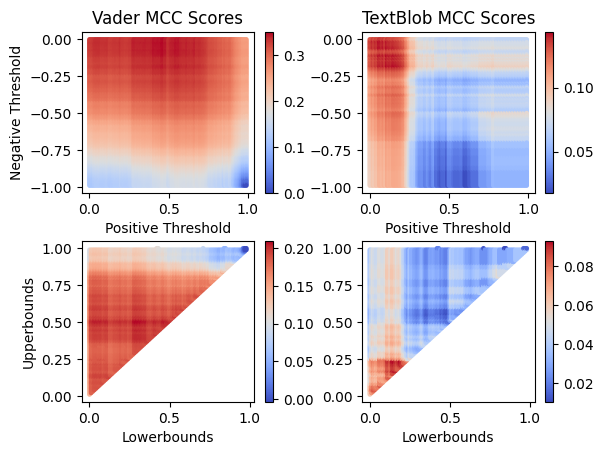

In [17]:
# Ablation analysis on ~75% (1800 samples)
subset = mySubset(data, 1800, 75)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

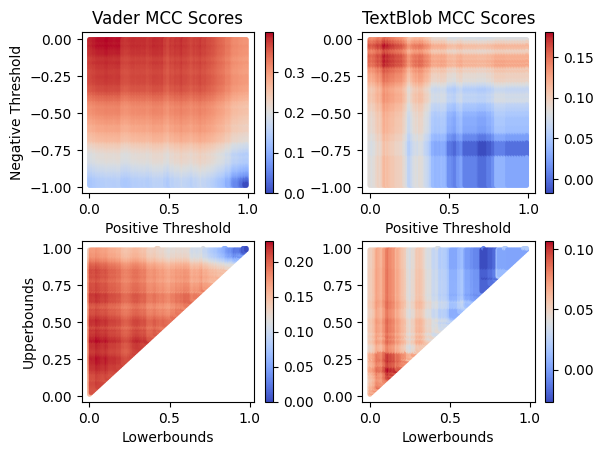

In [18]:
# Ablation analysis on ~50% (1200 samples)
subset = mySubset(data, 1200, 50)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

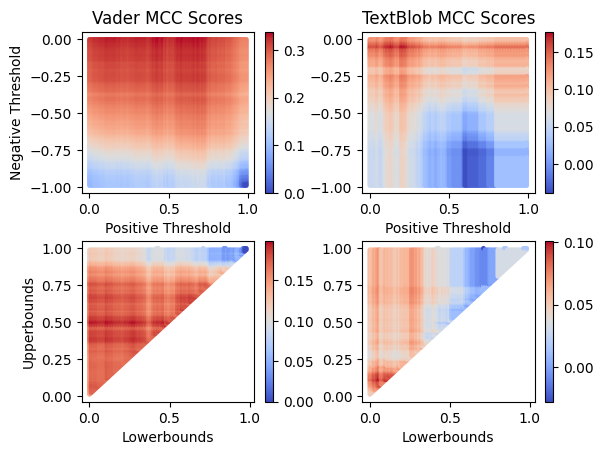

In [19]:
# Ablation analysis on ~33% (826 samples) - Also matching Khalil Dataset
subset = mySubset(data, 826, 33)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

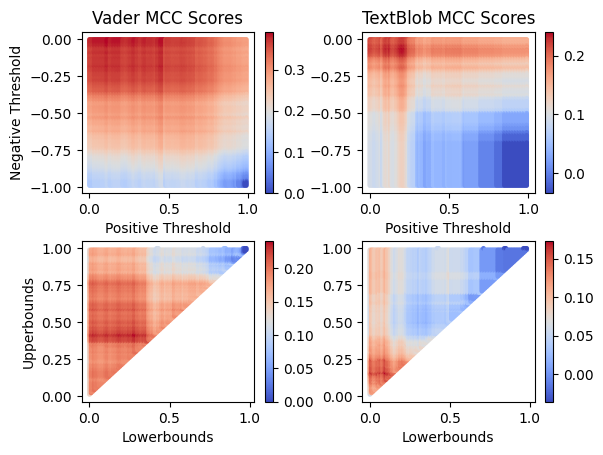

In [20]:
# Ablation analysis on ~20% (500 samples)
subset = mySubset(data, 500, 20)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

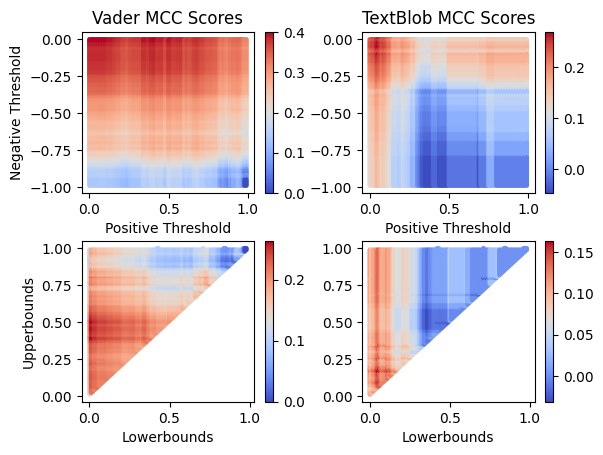

In [21]:
# Ablation analysis on ~10% (250 samples)
subset = mySubset(data, 250, 10)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

Ablation Analysis for MCC of the original thresholds

In [70]:
# useful functions

def threeClassMCC(scores, real, st):
  preds = []
  for s in scores:
    preds.append(polarity_score(s, st))
  return metrics.matthews_corrcoef(preds, real)

def fiveClassMCC(scores, real, lb, ub):
  preds = fcScore_list(scores, lb, ub)
  return metrics.matthews_corrcoef(preds, real)

def averageMCCs(ds, size, samples):
  tbMCCs_3c = []
  vMCCs_3c = []
  tbMCCs_5c = []
  vMCCs_5c = []
  for i in range(samples):
    subset = mySubset(ds, size, i)
    tbScores = subset["tbScores"]
    vScores = subset["vScores"]
    real3 = subset["real3"]
    real5 = subset["real5"]
    tbMCCs_3c.append(threeClassMCC(tbScores, real3, 0.01))
    vMCCs_3c.append(threeClassMCC(vScores, real3, 0.01))
    tbMCCs_5c.append(fiveClassMCC(tbScores, real5, 0.2, 0.6))
    vMCCs_5c.append(fiveClassMCC(vScores, real5, 0.2, 0.6))

  out = pd.DataFrame({"TextBlobMCCs_3c" : tbMCCs_3c,
                      "VaderMCCs_3c" : vMCCs_3c,
                      "TextBlobMCCs_5c" : tbMCCs_5c,
                      "VaderMCCs_5c" : vMCCs_5c})

  print("Average 3-Class MCC - TextBlob: ", np.mean(out["TextBlobMCCs_3c"]))
  print("Average 3-Class MCC - Vader: ", np.mean(out["VaderMCCs_3c"]))
  print("Average 5-Class MCC - TextBlob: ", np.mean(out["TextBlobMCCs_5c"]))
  print("Average 5-Class MCC - Vader: ", np.mean(out["VaderMCCs_5c"]))

  return out

In [73]:
# Calculating MCC on ~75% (1800 samples) of the data for original thresholds
out75 = averageMCCs(data, 1800, 50)


Average 3-Class MCC - TextBlob:  0.145613687617865
Average 3-Class MCC - Vader:  0.3461498149463228
Average 5-Class MCC - TextBlob:  0.048077481708266555
Average 5-Class MCC - Vader:  0.17369640462214392


In [74]:
# Calculating MCC on ~50% (1200 samples) of the data for original thresholds
out50 = averageMCCs(data, 1200, 50)

Average 3-Class MCC - TextBlob:  0.14569819301750436
Average 3-Class MCC - Vader:  0.3459917801997804
Average 5-Class MCC - TextBlob:  0.04829859416603629
Average 5-Class MCC - Vader:  0.17376903177914862


In [75]:
# Calculating MCC on ~33% (826 samples) of the data for original thresholds
out33 = averageMCCs(data, 826, 50)

Average 3-Class MCC - TextBlob:  0.1435075907093564
Average 3-Class MCC - Vader:  0.3424610829193031
Average 5-Class MCC - TextBlob:  0.048288555071880304
Average 5-Class MCC - Vader:  0.16904406568780633


In [76]:
# Calculating MCC on ~20% (500 samples) of the data for original thresholds
out20 = averageMCCs(data, 500, 50)

Average 3-Class MCC - TextBlob:  0.1396640099737756
Average 3-Class MCC - Vader:  0.3365581559939494
Average 5-Class MCC - TextBlob:  0.04552576542608526
Average 5-Class MCC - Vader:  0.16680955261149916


In [77]:
# Calculating MCC on ~10% (250 samples) of the data for original thresholds
out10 = averageMCCs(data, 250, 50)

Average 3-Class MCC - TextBlob:  0.14544104690658682
Average 3-Class MCC - Vader:  0.33984876349624116
Average 5-Class MCC - TextBlob:  0.04364597560792174
Average 5-Class MCC - Vader:  0.17392989530369


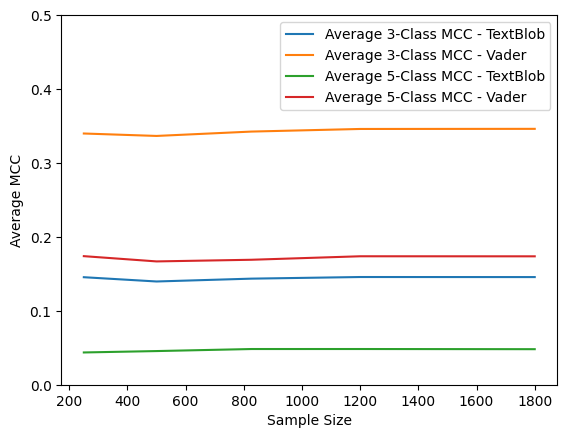

In [83]:
tb3c = [np.mean(out75["TextBlobMCCs_3c"]), np.mean(out50["TextBlobMCCs_3c"]), np.mean(out33["TextBlobMCCs_3c"]), np.mean(out20["TextBlobMCCs_3c"]), np.mean(out10["TextBlobMCCs_3c"])]
v3c = [np.mean(out75["VaderMCCs_3c"]), np.mean(out50["VaderMCCs_3c"]), np.mean(out33["VaderMCCs_3c"]), np.mean(out20["VaderMCCs_3c"]), np.mean(out10["VaderMCCs_3c"])]
tb5c = [np.mean(out75["TextBlobMCCs_5c"]), np.mean(out50["TextBlobMCCs_5c"]), np.mean(out33["TextBlobMCCs_5c"]), np.mean(out20["TextBlobMCCs_5c"]), np.mean(out10["TextBlobMCCs_5c"])]
v5c = [np.mean(out75["VaderMCCs_5c"]), np.mean(out50["VaderMCCs_5c"]), np.mean(out33["VaderMCCs_5c"]), np.mean(out20["VaderMCCs_5c"]), np.mean(out10["VaderMCCs_5c"])]
sampleSize = [1800, 1200, 826, 500, 250]

plt.plot(sampleSize, tb3c, label = "Average 3-Class MCC - TextBlob")
plt.plot(sampleSize, v3c, label = "Average 3-Class MCC - Vader")
plt.plot(sampleSize, tb5c, label = "Average 5-Class MCC - TextBlob")
plt.plot(sampleSize, v5c, label = "Average 5-Class MCC - Vader")
plt.xlabel("Sample Size")
plt.ylabel("Average MCC")
plt.ylim([0, 0.5])
plt.legend()

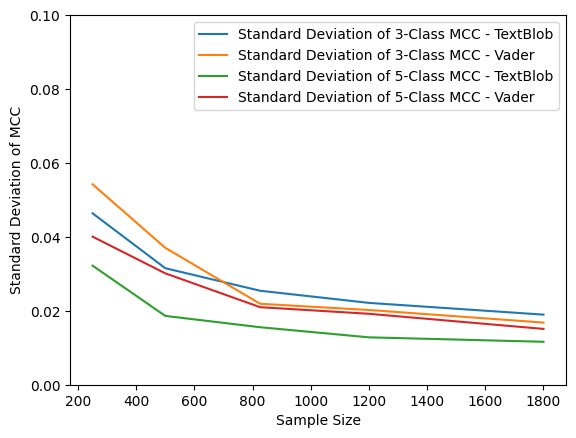

In [86]:
tb3c = [np.std(out75["TextBlobMCCs_3c"]), np.std(out50["TextBlobMCCs_3c"]), np.std(out33["TextBlobMCCs_3c"]), np.std(out20["TextBlobMCCs_3c"]), np.std(out10["TextBlobMCCs_3c"])]
v3c = [np.std(out75["VaderMCCs_3c"]), np.std(out50["VaderMCCs_3c"]), np.std(out33["VaderMCCs_3c"]), np.std(out20["VaderMCCs_3c"]), np.std(out10["VaderMCCs_3c"])]
tb5c = [np.std(out75["TextBlobMCCs_5c"]), np.std(out50["TextBlobMCCs_5c"]), np.std(out33["TextBlobMCCs_5c"]), np.std(out20["TextBlobMCCs_5c"]), np.std(out10["TextBlobMCCs_5c"])]
v5c = [np.std(out75["VaderMCCs_5c"]), np.std(out50["VaderMCCs_5c"]), np.std(out33["VaderMCCs_5c"]), np.std(out20["VaderMCCs_5c"]), np.std(out10["VaderMCCs_5c"])]
sampleSize = [1800, 1200, 826, 500, 250]

plt.plot(sampleSize, tb3c, label = "Standard Deviation of 3-Class MCC - TextBlob")
plt.plot(sampleSize, v3c, label = "Standard Deviation of 3-Class MCC - Vader")
plt.plot(sampleSize, tb5c, label = "Standard Deviation of 5-Class MCC - TextBlob")
plt.plot(sampleSize, v5c, label = "Standard Deviation of 5-Class MCC - Vader")
plt.xlabel("Sample Size")
plt.ylabel("Standard Deviation of MCC")
plt.ylim([0, 0.1])
plt.legend()